# Tecniche di modellizzazione e rappresentazione dati¶

## Andrea Cacciola A.A. 2023/2024

## Esercizio Parameter Regression

### Obiettivo

Data la funzione  𝑆𝐹𝑅𝐷=𝑓(𝑧,𝜃⃗ )
  che indica il tasso di formazione stellare per unità di volume, l'obiettivo dell'esercizio è quello di ricavare i valori del vettore $\vec{\theta} = 𝑓^{-1}(𝑆𝐹𝑅𝐷(𝑧))$
  con un approssimazione di una rete neuronale, con 
$\vec\theta =(\Omega_𝑚, \sigma_8,𝐴_{𝑆𝑁1}, 𝐴_{𝑆𝑁2},𝐴_{𝐴𝐺𝑁1},𝐴_{𝐴𝐺𝑁2})$.
 I primi due parametri sono parametri cosmologici legati alla densità di materia e all'ampiezza delle fluttuazioni del campo di materia, mentre i restanti 4  sono parametri astrofisici legati all'efficienza dei feedback energetici da espolosioni di supernovae e nuclei galattici attivi.
La rete neuronale sarà addestrata utilizzando i dati forniti dalle simulazioni per trovare una funzione approssimata che mappi la SFRD ai parametri desiderati. Una volta addestrata, la rete neurale sarà in grado di predire i parametri corrispondenti a nuovi valori di SFRD non visti durante l'addestramento. Per fare ciò, vengono utilizzati due file di dati:
il primo file contiene i dati della SFRD in funzione del redshift (z) misurata in ogni simulazione ; il secondo file contiene i valori dei parametri utilizzati per creare le simulazioni, ossia i parametri cosmologici e astrofisici menzionati precedentemente.

### SFRD vs Redshift per 5 simulazioni

Dopo aver importato tutte le librerie di Python che saranno utili per la risoluzione del problema

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import sys,os,time
import pandas
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

Sono stati scaricati e letti i file forniti contenenti i dati relativi alla funzione SFRD dipendente dal redshift z e i dati relativi ai parametri cosmologici. Inoltre il file .npy è stato trasformato in un file .txt perchè di più semplice apertura

In [24]:
sfrd_data = np.loadtxt(r'C:\Users\Admin\Documents\Python Scripts\SFRH_IllustrisTNG.txt')
parameters_data = np.loadtxt(r'C:\Users\Admin\Downloads\params_IllustrisTNG.txt')

Per visualizzare i parametri letti dai file precedentemente, vengono realizzati i grafici degli istogrammi con i loro valori

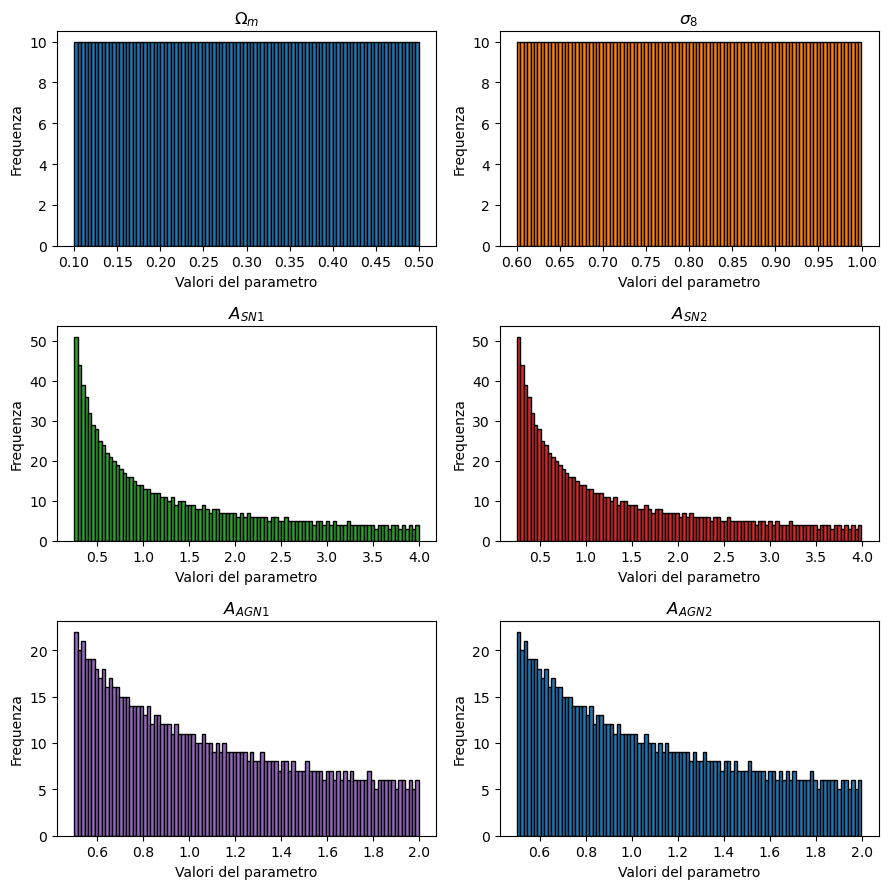

In [25]:
plt.figure(figsize=(9,9))
label = [r'$\Omega_{m}$',r'$\sigma_{8}$',r'$A_{SN1}$',r'$A_{SN2}$',r'$A_{AGN1}$',r'$A_{AGN2}$' ]
tablet = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple','tab:blue' ]
for j in range(6):
    plt.subplot(3, 2, j + 1)
    plt.hist(parameters_data[:, j], bins=100, color=tablet[j], edgecolor='black')

# Aggiungi etichette e titolo
    plt.xlabel('Valori del parametro')
    plt.ylabel('Frequenza')
    plt.title(label[j])
plt.tight_layout()
# Mostra l'istogramma
plt.show()

Estraggo 5 valori tra le simulazioni fornite e definisco l'array del redshift come scritto sul testo

In [26]:
# generazione di interi casuali in [0,999]
# Per selezionare casualmente 5 simulazioni utilizzo il comando di numpy random.choice.
#L'argomento replace=False indica che non si vuole che gli indici siano sostituiti dopo essere stati selezionati, quindi ogni indice sarà unico
indices = np.random.choice(len(sfrd_data), size=5, replace=False)
indices
# estrazione degli elementi corrispondenti agli indici selezionati

selected_sfrd = sfrd_data[indices]
selected_parameters = parameters_data[indices]
# Con il comando linspace costruisco un array composto da una serie di 100 elementi numerici equidistribuiti tra 0 e 7.
z = np.linspace(0.0, 7.0, 100)

Costruisco il grafico della SFRD in funzione dei redshift

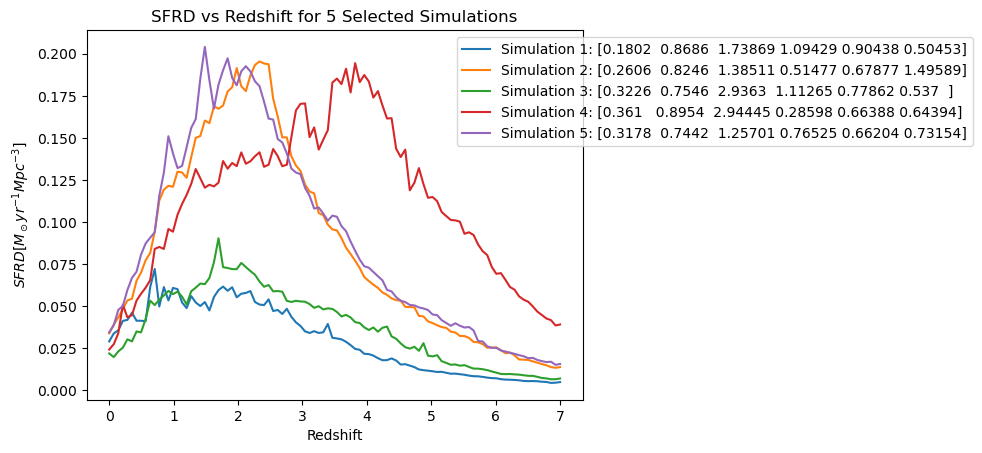

In [27]:
#Assegno il nome agli assi
plt.xlabel('Redshift')
plt.ylabel(r'$SFRD[M_\odot { yr}^{-1}{ Mpc}^{-3}]$')
#Assegno il nome del titolo al grafico
plt.title('SFRD vs Redshift for 5 Selected Simulations')
#Costruisco una paletta di 5 colori per distinguere ogni simulazione
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for i in range(5):
    plt.plot(z, selected_sfrd[i], color=colors[i])
#Inserisco una legenda che identifica per ogni simulazione effettuata i corrispondenti valori dei parametri cosmologici e astrofisici
#f'Simulation {i+1}' è una forma di formattazione della stringa che combina la parte statica "Simulation " con l'indice dell'iterazione i+1 per creare etichette uniche per le curve nel grafico.
#In questo caso, i+1 rappresenta l'indice dell'iterazione nel ciclo. Poiché Python usa indicizzazione partendo da 0, aggiungiamo 1 per ottenere gli indici da 1 a 5 anziché da 0 a 4. 
#Quindi, f'Simulation {i+1}' le stringhe: Simulation 1, Simulation 2, Simulation 3, Simulation 4, Simulation 5
legend_labels = []
for i in range(5):
    legend_labels.append(f'Simulation {i+1}: {selected_parameters[i]}')
#Con il comando bbox_to_anchor=(1.8, 1.0) ho posizionato la legenda al di fuori del grafico in modo che sia situata a 1.8 unità oltre l'angolo superiore destro del grafico e 1.0 unità sopra. 
#In questo modo, la legenda verrà posizionata fuori dal grafico e non sovrapporrà le curve.
plt.legend(legend_labels, loc='upper right',bbox_to_anchor=(1.8, 1.0)) 
plt.show()


### Costruzione della classe make_dataset() con suddivisione del data set

In questa sezione i dati forniti verranno preparati per essere analizzati dalla rete neuronale. Le reti neuronali lavorano con un batch size anziché con l'intero set di dati per diverse ragioni. In primo luogo, lavorare con un intero set di dati richiederebbe molta memoria, specialmente se il dataset è grande. Inoltre, l'uso di un batch size può stabilizzare l'addestramento e prevenire l'instabilità. I batch size più grandi spesso portano a una convergenza più rapida del modello rispetto ai batch size più piccoli o all'utilizzo dell'intero dataset. E' anche importante mischiare i dati perchè potrebbero essere presenti pattern di correlazione tra i campioni adiacenti nel dataset. Questo potrebbe portare a un addestramento non ottimale, poiché la rete potrebbe imparare a riconoscere eccessivamente questi pattern locali piuttosto che modelli più generali. Uso il pacchetto Dataloader di Pytorch che aiuta a caricare i dati in batch durante l'addestramento dei modelli di deep learning e definisco un set di parametri utili per la rete neuronale. In generale, sarebbe meglio spostare gli elementi di pytorch dalla cpu alla gpu perchè la scheda grafica del computer è più veloce a eseguire le operazioni fatte.  Tuttavia, PyTorch non supporta ufficialmente l'accelerazione hardware su GPU AMD attraverso l'uso di ROCm (Radeon Open Compute), pertanto non è possibile eseguire questa operazione.Infatti, attualmente PyTorch supporta principalmente le GPU NVIDIA attraverso CUDA. 

Definisco due variabili contenenti il percorso del file di testo

In [28]:
file_sfrd         = r'C:\Users\Admin\Documents\Python Scripts\SFRH_IllustrisTNG.txt'  
file_parameters       = r'C:\Users\Admin\Downloads\params_IllustrisTNG.txt'

In [69]:
# definizione del set di parametri e iperparametri

seed           = 1            #parametro che serve a mischiare i dati prima di dividerli in training, validation e test
min_valid_loss = 1e7          #valore molto alto della valid loss iniziale             
batch_size     = 32           # numero di elementi per ciascun batch
lr             = 0.0001         # learning rate
wd             = 0.0          # weight decay
dr             = 0.1          # dropout rate
epochs         = 370          # numero di epoche
hidden_size    = 120           #numero di neuroni per strato
patience       = 100          #Numero di epoche senza migliorare la funzione di perdita da attendere prima di aggiornare il learning rate
stop_criterion = 200          #Numero di epoche senza migliorare la funzione di perdita da attendere prima di interrompere l'addestramento

f_model        = 'best_model.pt'
     

In [70]:
# preparazione dei dati

def create_dataset(mode, file_sfrd, file_parameters, batch_size, seed):
    data_set = make_dataset(mode, file_sfrd, file_parameters, seed)
    return DataLoader(dataset = data_set, batch_size = batch_size, shuffle = True)
     

La creazione della classe make_dataset è fatta per suddividere il set di dati. Tuttavia è importante, dapprima, normalizzare i valori dei parametri e standardizzare i valori della funzione perchè può migliorare la stabilità numerica durante l'addestramento del modello. Ciò significa che le operazioni numeriche eseguite durante l'addestramento possono essere eseguite in modo più efficiente e con meno rischio di overflow o underflow. 
Il training set è il set di dati utilizzato per addestrare il modello di una rete neuronale. Durante il processo di addestramento, il modello "impara" dai dati di questo set attraverso la regolarizzazione dei parametri del modello.
Il validation set è utilizzato per regolare gli iperparametri del modello e valutare le sue prestazioni durante il processo di addestramento. È separato dal training set e contiene esempi di dati non utilizzati per l'addestramento. Dopo ogni epoca o iterazione di addestramento, il modello viene valutato sul validation set per monitorare le sue prestazioni e regolare gli iperparametri  per migliorare le prestazioni del modello. Il validation set aiuta a evitare l'overfitting, poiché fornisce una misura oggettiva delle prestazioni del modello su dati non utilizzati durante l'addestramento.  
Il test set è utilizzato per valutare le prestazioni finali del modello dopo che è stato addestrato e regolato utilizzando il training e il validation set.
È completamente separato dal training e dal validation set e non è utilizzato durante il processo di addestramento.
Il test set rappresenta un insieme indipendente di dati che il modello non ha mai visto prima.
Viene utilizzato per valutare le prestazioni del modello su dati "nuovi" e fornire una stima accurata delle sue capacità di generalizzazione su dati non visti.

In [71]:
class make_dataset():
    def __init__(self, mode, file_sfrd, file_parameters, seed):

        sfrd_data = np.loadtxt(file_sfrd)
        parameters_data = np.loadtxt(file_parameters)

        # standardizzazione della funzione
        sfrd_data[np.where(sfrd_data==0.0)] = 1e-12  # sostituzione di eventuali valori nulli
        mean = np.mean(sfrd_data, axis=0, dtype=np.float64)
        std  = np.std(sfrd_data,  axis=0, dtype=np.float64)
        sfrd_data = (sfrd_data - mean)/std

        # normalizzazione dei  parametri
        min_parameters = np.min(parameters_data, axis=0)
        max_parameters = np.max(parameters_data, axis=0)
        parameters_data = (parameters_data - min_parameters)/(max_parameters - min_parameters)

        n_training = sfrd_data.shape[0]
        columns = sfrd_data.shape[1]

        # divisione del campione
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    raise Exception('Wrong name!')

        # definizione dei tensori di input e output inizialmente nulli
        self.size   = size
        self.input  = torch.zeros((size,columns), dtype=torch.float) # SFRD
        self.output = torch.zeros((size,6), dtype=torch.float) # parametri

        # mescolamento dei dati
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size]

        # creazione degli array di input e output
        self.input  = torch.tensor(sfrd_data[indexes], dtype=torch.float32)
        self.output = torch.tensor(parameters_data[indexes], dtype=torch.float32)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]


Dove nell'ultima parte del codice len(self), restituisce la lunghezza totale del dataset. Mentre getitem(self, idx) restituisce l'input e l'output del campione corrispondente all'indice idx nel dataset quando accedi al dataset utilizzando dataset[idx]. Questi due metodi sono fondamentali quando si lavora con dataset personalizzati in PyTorch, poiché consentono di utilizzare la sintassi familiare delle liste o degli array per accedere ai campioni nel dataset.

In [72]:
train_loader = create_dataset('train', file_sfrd, file_parameters, batch_size, seed) #training dataset
valid_loader = create_dataset('valid', file_sfrd, file_parameters, batch_size, seed) #validation dataset

### Costruzione della rete neuronale per predire i valori dei parametri

Utilizzo un architettura del tipo nn.Linear, intervallata da una funzione di attivazione ReLu per la costruzione della rete. Nei modelli di rete neuronale, la funzione di attivazione viene utilizzata per introdurre non linearità nel modello. Senza una funzione di attivazione, la rete sarebbe solo una combinazione lineare di strati, e quindi sarebbe in grado di apprendere solo relazioni lineari tra le variabili di input e di output. L'introduzione di non linearità tramite funzioni di attivazione consente alla rete neurale di apprendere relazioni complesse tra le variabili di input e di output. La funzione ReLU (Rectified Linear Unit) è un buon esempio di funzione di attivazione perché è semplice ed efficiente. Essa è definita come $$ReLu=max(0,x)$$ In questa fase dell'esercizio ho scelto un numero arbitrario per gli iperparametri, lasciando l'ottimizzazione di essi alla sezione successiva. In questo caso ho scelto di costruire una rete con 4 strati nascosti e 120 neuroni per ogni strato

In [73]:
model = nn.Sequential(
            nn.Linear(100, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 6))



Nella seguente cella viene definita la loss function e l'ottimizzatore

In [74]:
# definizione di loss function e ottimizzatore

loss_func = nn.MSELoss()  #mean square error 
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

L'ottimizzatore Adam (Adaptive Moment Estimation) adatta il learning rate o durante l'allenamento per ogni parametro, il chè lo rende adatto per problemi in cui i gradienti possono variare notevolmente

Durante l'addestramento, il modello utilizza il training set per aggiornare i suoi pesi e i suoi parametri in modo da minimizzare una funzione detta funzione di perdita. Nel caso in esame, è stata considera la loss function mean square error $𝐿(\vec{\theta})=\frac{1}{N} \sum_{i} (\vec{\theta}_{𝑁𝑁}-\vec{\theta}_{𝑇𝑟𝑢𝑒})^2$

Questo processo avviene attraverso la discesa del gradiente. Dopo aver calcolato il gradiente, vengono aggiornati i valori dei parametri nella direzione opposta al gradiente della loss function. $\theta_{i+1}=\theta_𝑖-\lambda \nabla_{\theta} 𝐿(\theta)$
Dove 𝜆 è il learning rate (tasso di apprendimento), ossia un iperparametro che controlla la dimensione dei passi che un modello di machine learning prende durante l'ottimizzazione. In sostanza, determina quanto velocemente il modello cerca di imparare dai dati durante il processo di addestramento. Nel caso di algoritmi di ottimizzazione come la discesa del gradiente per aggiornare i pesi del modello durante l'addestramento, il learning rate indica la dimensione di ciascun passo in direzione opposta al gradiente. Un learning rate troppo piccolo può rallentare l'addestramento, mentre un learning rate troppo grande può causare oscillazioni o addirittura la divergenza del modello. Quindi, trovare il giusto learning rate è cruciale per l'addestramento efficace di un modello. 

In [75]:
start = time.time() # avvio cronometro

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience,
                                           min_lr= 1.0e-6, verbose=True)
epoch_best_model = 0

for epoch in range(epochs):

    # training
    train_loss, points = 0.0, 0 # la variabile points tiene conto della quantità
                                # di dati analizzati ad ogni epoca ed è utile per
                                # calcolare il valor medio della loss function
    model.train()
    for sfrd_train, parameters_train in train_loader:

        # dimensione del batch
        bs = sfrd_train.shape[0]

      

        # calcolo del valore previsto dalla rete
        parameters_pred  = model(sfrd_train)

        # calcolo della loss function
        loss = loss_func(parameters_pred, parameters_train)
        train_loss = train_loss + (loss.item())*bs # .item() estrae lo scalare dal tensore
        points = points + bs

        # ottimizzazione dei parametri
        optimizer.zero_grad() # azzeramento del gradiente
        loss.backward()       # calcolo del nuovo gradiente
        optimizer.step()      # calcolo dei nuovi parametri usando l'algoritmo di ottimizzazione

    # calcolo del valor medio
    train_loss = train_loss/points
    train_value[epoch] = train_loss

    # validation
    valid_loss, points = 0.0, 0
    model.eval()
    for sfrd_val, parameters_val in valid_loader:
        with torch.no_grad():   # siccome il valore del gradiente non è necessario,
                                # esso non viene calcolato per non occupare memoria
                                # inutilmente

            # dimensione del batch
            bs = sfrd_val.shape[0]

           
            # calcolo del valore previsto dalla rete
            parameters_pred = model(sfrd_val)
            
            valid_loss += (loss_func(parameters_pred, parameters_val).item())*bs
            points     = points + bs

    # calcolo del valor medio
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss)

    # ricerca del modello migliore
    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model)')
    else:
        print('')
    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break

stop = time.time() # spegnimento cronometro
print('Time taken (seconds):', "{:.4f}".format(stop-start))

epoch:0, valid loss: 0.2300 (best-model)
epoch:1, valid loss: 0.1620 (best-model)
epoch:2, valid loss: 0.1009 (best-model)
epoch:3, valid loss: 0.0840 (best-model)
epoch:4, valid loss: 0.0793 (best-model)
epoch:5, valid loss: 0.0741 (best-model)
epoch:6, valid loss: 0.0688 (best-model)
epoch:7, valid loss: 0.0643 (best-model)
epoch:8, valid loss: 0.0611 (best-model)
epoch:9, valid loss: 0.0589 (best-model)
epoch:10, valid loss: 0.0572 (best-model)
epoch:11, valid loss: 0.0563 (best-model)
epoch:12, valid loss: 0.0552 (best-model)
epoch:13, valid loss: 0.0548 (best-model)
epoch:14, valid loss: 0.0542 (best-model)
epoch:15, valid loss: 0.0541 (best-model)
epoch:16, valid loss: 0.0535 (best-model)
epoch:17, valid loss: 0.0527 (best-model)
epoch:18, valid loss: 0.0525 (best-model)
epoch:19, valid loss: 0.0522 (best-model)
epoch:20, valid loss: 0.0518 (best-model)
epoch:21, valid loss: 0.0519
epoch:22, valid loss: 0.0517 (best-model)
epoch:23, valid loss: 0.0509 (best-model)
epoch:24, valid

epoch:253, valid loss: 0.0448
epoch:254, valid loss: 0.0450
epoch:255, valid loss: 0.0447
epoch:256, valid loss: 0.0445
epoch:257, valid loss: 0.0444
epoch:258, valid loss: 0.0444
epoch:259, valid loss: 0.0453
epoch:260, valid loss: 0.0441
epoch:261, valid loss: 0.0447
epoch:262, valid loss: 0.0448
epoch:263, valid loss: 0.0455
epoch:264, valid loss: 0.0454
epoch:265, valid loss: 0.0447
epoch:266, valid loss: 0.0453
epoch:267, valid loss: 0.0443
epoch:268, valid loss: 0.0451
epoch:269, valid loss: 0.0448
epoch:270, valid loss: 0.0440
epoch:271, valid loss: 0.0450
epoch:272, valid loss: 0.0441
epoch:273, valid loss: 0.0445
epoch:274, valid loss: 0.0444
epoch:275, valid loss: 0.0448
epoch:276, valid loss: 0.0448
epoch:277, valid loss: 0.0448
epoch:278, valid loss: 0.0442
epoch:279, valid loss: 0.0443
epoch:280, valid loss: 0.0446
epoch:281, valid loss: 0.0445
epoch:282, valid loss: 0.0440
epoch:283, valid loss: 0.0450
epoch:284, valid loss: 0.0442
epoch:285, valid loss: 0.0436
epoch:286,

Traccio adesso il grafico delle due loss function in funzione del numero di epoche

[]

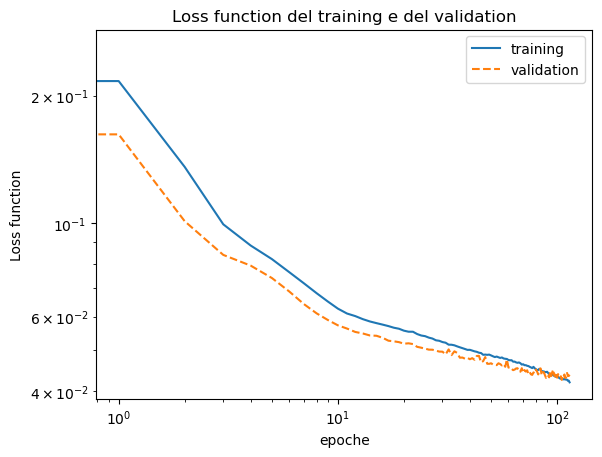

In [76]:
epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='training')
plt.plot(epoche,valid_value[:epoch_best_model],ls='--',label='validation')
plt.legend()

plt.title("Loss function del training e del validation")
plt.xlabel("epoche")
plt.ylabel("Loss function")
plt.loglog()

Dal grafico possiamo osservare l'andamento della loss function del training e del validation in funzione del numero di epoche. Entrambe le funzioni decrescono, al crescere del numero di epoche. Mentre la loss function del validation raggiunge un plaetau dopo circa 90 epoche, si osserva che quella del training continua a decrescere. Quando la loss function raggiunge il plateau significa che la riduzione della loss si è stabilizzata e non diminuisce significativamente anche se il modello continua ad essere allenato. Durante le prime fasi dell'addestramento, sia la training loss che la validation loss diminuiscono gradualmente. Successivamente, si osserva che la validation loss diventi maggiore della training loss dopo circa 100 epoche. Quando si verifica un plateau nella validation loss senza un corrispondente plateau nella training loss, potrebbe indicare che il modello sta iniziando l'overfitting sui dati di addestramento. Questo fenomeno può verificarsi quando il modello impara troppo dai dati di addestramento e non è in grado di generalizzare bene sui dati del validation set.

### Ottimizzazione degli iperparametri

I dati degli iperparametri sono stati finora inseriti in modo arbitrario, in questa sezione verranno determinati i valori del learning rate, del numero di epoche, del numero di strati di neuroni e del numero di neuroni per strato che ottimizzano la rete neuronale. Per fare questo viene utilizzata la libreria di python optuna. Nella seguente cella, viene definita una funzione objective(trial) che prende come argomento un oggetto trial di Optuna. All'interno di questa funzione, vengono suggeriti i valori per gli iperparametri da ottimizzare, come il tasso di apprendimento lr, la dimensione degli strati nascosti hidden_size, il numero di epoche epochs, e il numero di layer num_layers. Per il learning rate viene utilizzata una distribuzione loguniforme in quanto può coprire un intervallo molto ampio di valori in modo logaritmico, mentre per gli altri iperparametri viene suggerito un numero intero per degli intervalli scelti come plausibili. 
Successivamente, viene creato il modello della rete neurale come in precedenza con gli iperparametri suggeriti da optuna, 
con la funzione di perdita (MSELoss) e l'ottimizzatore (Adam).Infine è stato creato uno studio di Optuna con la direzione di minimizzare la funzione obiettivo. Viene chiamato study.optimize per eseguire l'ottimizzazione degli iperparametri, specificando il numero di tentativi da eseguire (n_trials). Ogni tentativo corrisponde a un set diverso di iperparametri suggeriti e valutati.

 

In [78]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_size)])
        self.hidden_layers.extend([nn.Linear(hidden_size, hidden_size) for _ in range(4)])  # 4 hidden layers
        self.output_layer = nn.Linear(hidden_size, 6)
    #La funzione di inoltro viene utilizzata per propagare l'input attraverso il modello e ottenere l'output    
    def forward(self, input_values):
        for layer in self.hidden_layers:
            input_values = torch.relu(layer(input_values))
        input_values = self.output_layer(input_values)
        return input_values
  
# Definisco la funzione di obiettivo per l'ottimizzazione di Optuna (includo tutto l'algoritmo dentro la funzione obiettivo)
def objective(trial):
    # Iperparametri da ottimizzare
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_size = trial.suggest_int('hidden_size', 30, 200)
    epochs = trial.suggest_int('epochs', 100, 500)  # Intervallo ragionevole per il numero di epoche
    num_layers = trial.suggest_int('num_layers', 1, 10)  # Intervallo ragionevole per il numero di layer

    # Creazione del modello
    model = NeuralNetwork(input_size=100, hidden_size=hidden_size)
    
    # Definizione della loss function e dell'ottimizzatore
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    train_loader = create_dataset('train', file_sfrd, file_parameters, batch_size, seed)
    valid_loader = create_dataset('valid', file_sfrd, file_parameters, batch_size, seed)
    # Addestramento del modello
    for epoch in range(epochs):

    # training
        train_loss, points = 0.0, 0 # la variabile points tiene conto della quantità
                                # di dati analizzati ad ogni epoca ed è utile per
                                # calcolare il valor medio della loss function
        model.train()
        for sfrd_train, parameters_train in train_loader:
       # dimensione del batch
            bs = sfrd_train.shape[0]
        # calcolo del valore previsto dalla rete
            parameters_pred  = model(sfrd_train)

        # calcolo della loss function
            loss = loss_func(parameters_pred, parameters_train)
            train_loss = train_loss + (loss.item())*bs # .item() estrae lo scalare dal tensore
            points = points + bs

        # ottimizzazione dei parametri
            optimizer.zero_grad() # azzeramento del gradiente
            loss.backward()       # calcolo del nuovo gradiente
            optimizer.step()      # calcolo dei nuovi parametri usando l'algoritmo di ottimizzazione

    # calcolo del valor medio
        train_loss = train_loss/points
        train_value[epoch] = train_loss

    # validation
        valid_loss, points = 0.0, 0
        model.eval()
        for sfrd_val, parameters_val in valid_loader:
            with torch.no_grad():   # siccome il valore del gradiente non è necessario,
                                # esso non viene calcolato per non occupare memoria
                                # inutilmente

            # dimensione del batch
                bs = sfrd_val.shape[0]

           
            # calcolo del valore previsto dalla rete
                parameters_pred = model(sfrd_val)
            
                valid_loss += (loss_func(parameters_pred, parameters_val).item())*bs
                points     = points + bs

    # calcolo del valor medio
        valid_loss /= points
        valid_value[epoch]=valid_loss

        scheduler.step(valid_loss)

        return valid_loss





study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

# Ottieni i migliori iperparametri trovati
best_parameters = study.best_params
print("Best parameters:", best_parameters)


best_lr = best_parameters['lr']
best_hidden_size = best_parameters['hidden_size']
best_epochs = best_parameters['epochs']
best_num_layers = best_parameters['num_layers']



[I 2024-03-17 15:24:50,583] A new study created in memory with name: no-name-23afa6cf-7562-4819-94b8-60ddeaa7d449
[I 2024-03-17 15:24:50,733] Trial 0 finished with value: 0.0634592913587888 and parameters: {'lr': 0.002272692924237638, 'hidden_size': 103, 'epochs': 187, 'num_layers': 3}. Best is trial 0 with value: 0.0634592913587888.
[I 2024-03-17 15:24:50,905] Trial 1 finished with value: 0.07485430975755056 and parameters: {'lr': 0.0009684061062973968, 'hidden_size': 128, 'epochs': 239, 'num_layers': 8}. Best is trial 0 with value: 0.0634592913587888.
[I 2024-03-17 15:24:51,076] Trial 2 finished with value: 0.05784061138828595 and parameters: {'lr': 0.005841166663541253, 'hidden_size': 113, 'epochs': 480, 'num_layers': 4}. Best is trial 2 with value: 0.05784061138828595.
[I 2024-03-17 15:24:51,249] Trial 3 finished with value: 0.18721669375896455 and parameters: {'lr': 0.0001249258442605264, 'hidden_size': 123, 'epochs': 474, 'num_layers': 1}. Best is trial 2 with value: 0.0578406113

[I 2024-03-17 15:24:56,947] Trial 36 finished with value: 0.07964767297108968 and parameters: {'lr': 0.0007930575659224849, 'hidden_size': 116, 'epochs': 460, 'num_layers': 2}. Best is trial 25 with value: 0.05534875412782033.
[I 2024-03-17 15:24:57,098] Trial 37 finished with value: 0.0829032850265503 and parameters: {'lr': 0.0017805565331621644, 'hidden_size': 130, 'epochs': 490, 'num_layers': 4}. Best is trial 25 with value: 0.05534875412782033.
[I 2024-03-17 15:24:57,258] Trial 38 finished with value: 0.09349401811758677 and parameters: {'lr': 0.0011559142057401956, 'hidden_size': 63, 'epochs': 309, 'num_layers': 6}. Best is trial 25 with value: 0.05534875412782033.
[I 2024-03-17 15:24:57,468] Trial 39 finished with value: 0.06107510288556417 and parameters: {'lr': 0.004977756777605351, 'hidden_size': 157, 'epochs': 373, 'num_layers': 9}. Best is trial 25 with value: 0.05534875412782033.
[I 2024-03-17 15:24:57,652] Trial 40 finished with value: 0.26092200458049775 and parameters: {

Best parameters: {'lr': 0.006375155873067437, 'hidden_size': 93, 'epochs': 291, 'num_layers': 8}


 E' stato creato un file csv per visualizzare tutte le combinazioni degli iperparametri con i relativi trials

In [79]:
# Ottieni un DataFrame con le informazioni sui trial
trials_df = study.trials_dataframe()

# Salva il DataFrame come file CSV
trials_df.to_csv('parametri_trials.csv', index=False)

### Confronto tra i valori predetti dalla rete neuronale con quelli veri per il test set.

Nella prossima cella viene eseguito il test finale del modello allenato sul set di dati di test. Analogagamente a quanto fatto prima, viene utilizzata la funzione create_dataset per creare un DataLoader per il set di dati di test utilizzando i file di dati file_sfrd e file_parameters con un determinato batch_size e seed. Vengono eseguite iterazioni attraverso il DataLoader per il set di dati di test. Durante ogni iterazione, il modello viene utilizzato per fare previsioni sui dati di input (sfrd_test) e i risultati vengono confrontati con i valori di output attesi (parameters_test). I valori previsti e i valori reali dei parametri vengono salvati in array numpy (parameters_NN e parameters_true). Infine, viene calcolata  anche la loss function utilizzando i valori predetti e quelli reali e la loss totale viene divisa per il numero totale di punti nel set di dati di test per ottenere la loss media.

In [80]:
test_loader = create_dataset('test', file_sfrd, file_parameters, batch_size, seed) #test dataset



# test
sfrd_values=np.zeros((int(sfrd_data.shape[0]*0.15),100), dtype=np.float32)
parameters_true = np.zeros((int(parameters_data.shape[0]*0.15),6), dtype=np.float32)
parameters_NN = np.zeros((int(parameters_data.shape[0]*0.15),6), dtype=np.float32)

offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0

for sfrd_test, parameters_test in test_loader:
    with torch.no_grad():

        bs = sfrd_test.shape[0]

        

        # calcolo dei valori previsti dalla rete
        parameters_pred = model(sfrd_test)

        # memorizzazione dei valori reali e calcolati dei parametri
        # spostamento dei dati alla CPU e traduzione in array Numpy

        sfrd_values[counter:counter+bs,:]=sfrd_test.numpy()
        parameters_true[counter:counter+bs,:]= parameters_test.numpy()
        parameters_NN[counter:counter+bs,:]= parameters_pred.numpy()

        test_loss += (loss_func(parameters_pred, parameters_test).item())*sfrd_test.shape[0]
        points += sfrd_test.shape[0]

        counter += bs

# calcolo del valore medio
test_loss /= points

print('test loss = %.3e'%test_loss)

test loss = 4.731e-02


Viene costruita una griglia contenente 6 grafici ognuno relativo ad ogni parametro in cui nelle ascisse di ogni grafico sono presenti i valori veri dei parametri e in ordinata i valori predetti dalla rete. Questi subplot sono organizzati in una griglia 3x2.Per ciascun parametro, viene eseguito un grafico a dispersione (plt.scatter) con i valori reali (parameters_true[:, j]) sull'asse x e i valori predetti (parameters_NN[:, j]) sull'asse y. Successivamente, è stata tracciata una linea di riferimento che rappresenta una stima perfetta in cui i valori reali e quelli predetti coincidono. Se tutti i punti dello scatter appartenessero alla linea allora la predizione della rete neurale sarebbe perfetta, ossia il modello costruito rispetta esattamente i valori dei parametri reali.

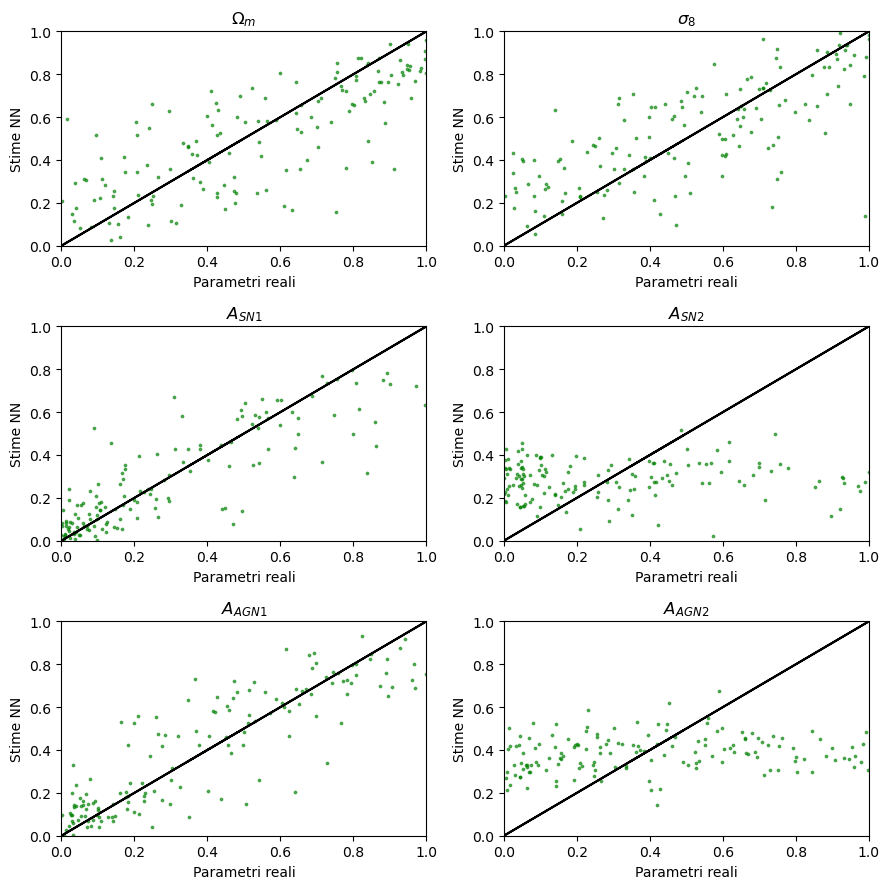

In [81]:
# produzione del  grafico
label = [r'$\Omega_{m}$',r'$\sigma_{8}$',r'$A_{SN1}$',r'$A_{SN2}$',r'$A_{AGN1}$',r'$A_{AGN2}$' ]
plt.figure(figsize=(9, 9))
# genero numeri con distribuzione uniforme
u= np.random.uniform(0, 1, 1000)
#ciclo per creare griglia per ogni parametro
for j in range(6):
    plt.subplot(3, 2, j + 1)
    plt.scatter(parameters_true[:, j], parameters_NN[:, j], s = 3, color='green',alpha=0.6, marker='o')
    #eq retta y=x 
    plt.plot(u, u, color='black') 
    plt.title(label[j])
    plt.xlabel('Parametri reali')
    plt.ylabel('Stime NN')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Dai grafici possiamo osservare andamenti diversi dello scatter per i vari parametri. Sembra che per i parametri $A_{SN1}$ e $A_{AGN1}$ il modello costruito si avvicini molto ai valori reali. Un andamento meno sperato si visualizza per i parametri $A_{SN2}$ e $A_{AGN2}$ in cui i valori dei puntini riempono tutto il grafico (il primo con maggiore concentrazione verso numeri vicini allo 0, il secondo riempie indistintamente tutto il grafico). Per i parametri cosmologici non è semplice fare un confronto dalla semplice osservazione del grafico

Per avere un'idea più quantitativa viene costruita una rete neuronale che predice anche gli erorri oltre che i valori dei parametri

### Stima dell'errore sui parametri

In questa sezione verrà riapplicato lo stesso algoritmo utilizzato precedentemente, con una loss function che non è più Mean Square Error, ma tiene conto di un termine aggiuntivo dovuto all'errore $$L(\vec{\theta}) = log \sum_{i} (\vec{\theta}_i-\hat{\vec{\theta}}_i)^2 + \log \sum_{i} (\vec{\theta}_i^2 - \vec{\sigma_i}^2)^2$$
Questa volta, nella rete neuronale costruita non ci saranno più 6 valori di output ma 12 perchè ad ogni parametro è associato il proprio errore


In [82]:
seed           = 1
min_valid_loss = 1e7                       
batch_size     = 32                        # numero di elementi per ciascun batch
lr             = 0.0002                      # learning rate
wd             = 0.0                       # weight decay
dr             = 0.1                       # dropout rate
epochs         = 130                       # numero di iterazioni (epoche)
hidden_size    = 89
patience       = 100
stop_criterion = 200
f_model        = 'best_model.pt'

In [83]:
model = nn.Sequential(
            nn.Linear(100, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 12)) #in output ci sono i 6 parametri e i relativi errori


# creazione dei dataset
train_loader = create_dataset('train', file_sfrd, file_parameters, batch_size, seed) #training dataset
valid_loader = create_dataset('valid', file_sfrd, file_parameters, batch_size, seed) #validation dataset

Ecco la classe in cui viene definita la nuova loss function

In [84]:
class loss_function(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, parameters_error_pred, parameters_train):
        num_parameters = parameters_error_pred.shape[1] // 2
        loss=0.0
      #   si assume che parametri e rispettivi errori si alternino
        for i in range(num_parameters):
            loss += torch.log(torch.sum((parameters_train[:,i] - parameters_error_pred[:,2*i])**2)) + torch.log(torch.sum(((parameters_train[:,i]-parameters_error_pred[:,2*i])**2. - parameters_error_pred[:,2*i+1]**2.)**2.))
          
        return loss

# definizione di loss function e ottimizzatore
loss_func = loss_function()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

In [85]:
start = time.time() # accensione cronometro

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

min_valid_loss_param=min_valid_loss

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience,
                                           min_lr= 1.0e-6, verbose=True)

epoch_best_model = 0

for epoch in range(epochs):

    # training
    train_loss, points = 0.0, 0
    model.train()
    for sfrd_train, parameters_train in train_loader:

         # dimensione del batch
        bs = sfrd_train.shape[0]

       

        # calcolo del valore previsto dalla rete
        parameters_error_pred  = model(sfrd_train)

        # calcolo della loss function
        loss = loss_func(parameters_error_pred, parameters_train)
        train_loss += (loss.item())
        points     += bs

        # ottimizzazione dei parametri
        optimizer.zero_grad() # azzeramento del gradiente
        loss.backward()       # calcolo del nuovo gradiente
        optimizer.step()      # calcolo dei nuovi parametri usando l'algoritmo di ottimizzazione


    # calcolo del valor medio
    train_loss /= points
    train_value[epoch]=train_loss


    # validation
    valid_loss, points = 0.0, 0
    model.eval()
    for sfrd_val, parameters_val in valid_loader:
        with torch.no_grad():

             # dimensione del batch
            bs = sfrd_val.shape[0]

            

            # calcolo del valore previsto dalla rete
            parameters_error_pred  = model(sfrd_val)
            valid_loss += (loss_func(parameters_error_pred, parameters_val).item())
            points     += bs

    # calcolo del valore medio
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss)

    # ricerca del modello migliore
    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model)')
    else:
        print('')
    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break

stop = time.time() # spegnimento cronometro
print('Time taken (seconds):', "{:.4f}".format(stop-start))

epoch:0, valid loss: 0.4442 (best-model)
epoch:1, valid loss: -0.0883 (best-model)
epoch:2, valid loss: -0.1863 (best-model)
epoch:3, valid loss: -0.2576 (best-model)
epoch:4, valid loss: -0.2881 (best-model)
epoch:5, valid loss: -0.3290 (best-model)
epoch:6, valid loss: -0.3287
epoch:7, valid loss: -0.3630 (best-model)
epoch:8, valid loss: -0.3800 (best-model)
epoch:9, valid loss: -0.3688
epoch:10, valid loss: -0.3813 (best-model)
epoch:11, valid loss: -0.3928 (best-model)
epoch:12, valid loss: -0.3811
epoch:13, valid loss: -0.4048 (best-model)
epoch:14, valid loss: -0.3956
epoch:15, valid loss: -0.3776
epoch:16, valid loss: -0.3974
epoch:17, valid loss: -0.3961
epoch:18, valid loss: -0.4018
epoch:19, valid loss: -0.3874
epoch:20, valid loss: -0.3997
epoch:21, valid loss: -0.4062 (best-model)
epoch:22, valid loss: -0.3987
epoch:23, valid loss: -0.4163 (best-model)
epoch:24, valid loss: -0.4173 (best-model)
epoch:25, valid loss: -0.3863
epoch:26, valid loss: -0.4362 (best-model)
epoch:

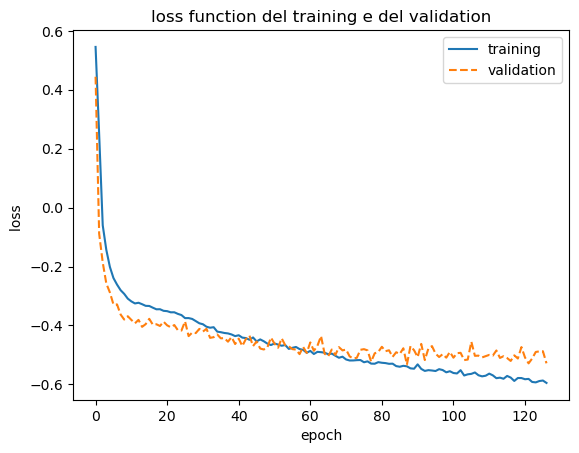

In [86]:
# realizzazione grafico
epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='training')
plt.plot(epoche,valid_value[:epoch_best_model],ls='--',label='validation')

plt.legend()
plt.title("loss function del training e del validation")
plt.xlabel("epoch")
plt.ylabel("loss ")
plt.show()

Dal grafico si osserva un andamento decrescente di entrambe le loss function. In particolare, le curve decrescono molto velocemente fino a 10 epoche, in seguito la decrescita avviene lentamente. La validation loss raggiunge un plaetau dopo circa 50 epoche e il suo valore supera quello della training loss dopo circa 60 epoche

Analogamente a quanto fatto prima, viene fatto un confronto tra i valori predetti dalla rete neuronale con quelli veri per il test set. 

In [87]:
test_loader = create_dataset('test', file_sfrd, file_parameters, batch_size, seed) #test data



# test
sfrd_values=np.zeros((int(sfrd_data.shape[0]*0.15),100), dtype=np.float32)
parameters_true = np.zeros((int(parameters_data.shape[0]*0.15),6), dtype=np.float32)
parameters_NN = np.zeros((int(parameters_data.shape[0]*0.15),6), dtype=np.float32)
err_NN = np.zeros((int(parameters_data.shape[0]*0.15),6), dtype=np.float32)

offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
for sfrd_test, parameters_test in test_loader:
    with torch.no_grad():

        bs = sfrd_test.shape[0]

        

        # calcolo dei valori previsti dalla rete
        parameters_error_pred  = model(sfrd_test)

       
        # traduzione in array Numpy

        sfrd_values[counter:counter+bs,:]=sfrd_test.numpy()
        parameters_true[counter:counter+bs,:]= parameters_test.numpy()
        parameters_NN[counter:counter+bs,:]= parameters_error_pred[:, ::2].numpy()
        err_NN[counter:counter+bs,:] = parameters_error_pred[:, 1::2].numpy()

        # compute cumulative loss and number of examples used
        test_loss += (loss_func(parameters_error_pred, parameters_test))
        points += sfrd_test.shape[0]

        counter += bs

# calcolo del valore medio
test_loss /= points

print('test loss = %.3e'%test_loss)


test loss = -4.680e-01


Vengono riportati in seguito i grafici relativi ai 6 parametri

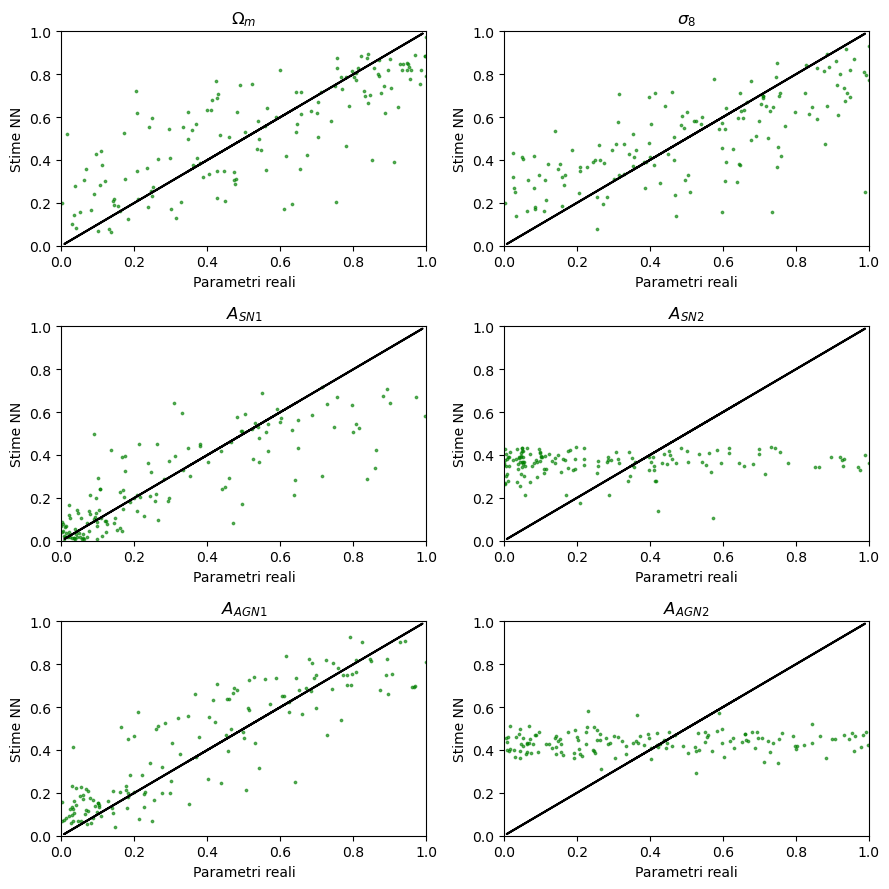

In [88]:
# produzione del grafico

label = [r'$\Omega_{m}$',r'$\sigma_{8}$',r'$A_{SN1}$',r'$A_{SN2}$',r'$A_{AGN1}$',r'$A_{AGN2}$' ]

plt.figure(figsize=(9,9))

u= np.random.uniform(0, 1, 150)
#ciclo per creare griglia per ogni parametro
for j in range(6):
    plt.subplot(3, 2, j + 1)
    plt.scatter(parameters_true[:, j], parameters_NN[:, j], s = 3, color='green',alpha=0.6, marker='o')
    #eq retta y=x 
    plt.plot(u, u, color='black') 
    plt.title(label[j])
    plt.xlabel('Parametri reali')
    plt.ylabel('Stime NN')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
#sistma automaticamente il layout    
plt.tight_layout()
plt.show()

In [89]:
num_within_1_error = []
num_within_2_errors = []
num_within_3_errors = []

for j in range(6):  # Ciclo su ogni parametro
    # Calcoliamo la distanza euclidea normalizzata tra i punti dello scatter e la retta y = x per il parametro j
    #A, B, C = 1, -1, 0  # Coefficienti dell'equazione della bisettrice
    #distanza= np.abs(A * parameters_true[:,j] + B * parameters_NN[:,j] + C) / np.sqrt(A**2 + B**2)
    distanza = np.abs(parameters_NN[:, j] - parameters_true[:, j]) / np.sqrt(2)

    # seleziono i punti che si trovano entro 1 errore dalla retta y = x per il parametro j
    within_1_error = distanza < np.abs(1*err_NN[:,j])
    # seleziono i punti che si trovano entro 1 errore dalla retta y = x per il parametro j
    within_2_errors = distanza < np.abs(2*err_NN[:,j])
    # seleziono i punti che si trovano entro 3 errori dalla retta y = x per il parametro j
    within_3_errors = distanza < np.abs(3*err_NN[:,j])

    # Calcoliamo il numero di punti che soddisfano ciascun criterio per il parametro j
    num_within_1_error.append(np.sum(within_1_error))
    num_within_2_errors.append(np.sum(within_2_errors))
    num_within_3_errors.append(np.sum(within_3_errors))

# Stampiamo i risultati per ciascun parametro
label = ['\u03A9_m','\u03C3_{8}','A_{SN1}','A_{SN2}','A_{AGN1}','A_{AGN2}' ]
for j in range(6):
    print("Parametro:", label[j])
    print(np.abs(err_NN[:,j]))
    print("Numero di punti entro 1 errore dalla retta y = x:", num_within_1_error[j])
    print("Numero di punti entro 2 errori dalla retta y = x:", num_within_2_errors[j])
    print("Numero di punti entro 3 errori dalla retta y = x:", num_within_3_errors[j])
    print("")

Parametro: Ω_m
[0.14896394 0.14480357 0.1128943  0.17397447 0.08700517 0.1703173
 0.12644508 0.16843694 0.1751485  0.11903237 0.07161501 0.12795313
 0.17261165 0.13530631 0.14422691 0.13396661 0.18431601 0.1340876
 0.14113669 0.19825558 0.12439919 0.13376452 0.12740475 0.1592105
 0.13863584 0.16069712 0.10959324 0.14963876 0.1422988  0.14169846
 0.15709183 0.18185744 0.19003311 0.1302661  0.1274043  0.10891483
 0.11788644 0.15059942 0.14557472 0.11243677 0.1606335  0.11028582
 0.14716741 0.12732254 0.13032416 0.14324448 0.20513302 0.19331351
 0.09569001 0.16657269 0.17063114 0.19890738 0.12819885 0.10631683
 0.11191666 0.1129888  0.1196908  0.14050113 0.168925   0.15737683
 0.12042293 0.13694465 0.09738918 0.1613842  0.18569176 0.07852309
 0.14353989 0.09510665 0.1442836  0.1291289  0.15130049 0.14334181
 0.16446134 0.12451178 0.15679532 0.15172902 0.18165512 0.1760773
 0.16788179 0.13083519 0.14708462 0.11199213 0.13310754 0.16557446
 0.1633679  0.17265633 0.08360223 0.12533276 0.1806

Dai valori ottenuti è possibile osservare che i valori stimati con la neural network di $A_{SN2}$ e $A_{AGN2}$ sono quelli che sono stimati meglio dal modello. Sebbene dallo scatter plot sembri che  $A_{SN1}$ e $A_{AGN1}$ siano i parametri stimati meglio, contando quanti punti rientrano nell'intervallo corrispondente ad 1 deviazione standard e 3 deviazioni standard si osserva che le fasce relative ai parametri $A_{SN2}$ e $A_{AGN2}$ sono quelle che raccolgono un numero di punti maggiore.   

Ciò è dovuto al fatto che proprio questi ultimi 2 parametri sono quelli ad avere un errore maggiore cosi' come visibile dai valori stampati.